<br>

<h1 style="text-align: center;">Causal Inference with DoubleML: Job Training Impact Analysis</h1>

<br>

## Initial Setup

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from doubleml import DoubleMLPLR, DoubleMLIRM
from doubleml import DoubleMLData
from scipy import stats

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Set matplotlib style
plt.style.use('ggplot')

<br>

## Load and Prepare Dataset

---

In [4]:
# Load the LaLonde dataset
url = "https://raw.githubusercontent.com/robjellis/lalonde/master/lalonde_data.csv"
df = pd.read_csv(url)
df.head()

,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [5]:
# Prepare the data
y_col = 're78'  # 1978 earnings (outcome)
d_col = 'treat'  # Treatment indicator
x_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

In [6]:
# Create DoubleMLData object
dml_data = DoubleMLData(df, y_col, d_col, x_cols)

In [7]:
# Standardize continuous variables
scaler = StandardScaler()
df[['age', 'educ', 're74', 're75']] = scaler.fit_transform(df[['age', 'educ', 're74', 're75']])


<br>

## Exploratory Data Analysis (EDA)

---

In [8]:
# Basic statistics
print(df.describe())

            treat           age          educ       black      hispan  \
count  614.000000  6.140000e+02  6.140000e+02  614.000000  614.000000   
mean     0.301303  1.128305e-16 -1.301890e-16    0.395765    0.117264   
std      0.459198  1.000815e+00  1.000815e+00    0.489413    0.321997   
min      0.000000 -1.150920e+00 -3.910134e+00    0.000000    0.000000   
25%      0.000000 -7.457804e-01 -4.831078e-01    0.000000    0.000000   
50%      0.000000 -2.393557e-01  2.784536e-01    0.000000    0.000000   
75%      1.000000  4.696387e-01  6.592343e-01    1.000000    0.000000   
max      1.000000  2.799192e+00  2.943919e+00    1.000000    1.000000   

          married    nodegree          re74        re75          re78  
count  614.000000  614.000000  6.140000e+02  614.000000    614.000000  
mean     0.415309    0.630293 -4.628943e-17    0.000000   6792.834483  
std      0.493177    0.483119  1.000815e+00    1.000815   7470.730792  
min      0.000000    0.000000 -7.041197e-01   -0.66351

In [9]:
# Treatment group sizes
print(df['treat'].value_counts(normalize=True))

treat
0    0.698697
1    0.301303
Name: proportion, dtype: float64


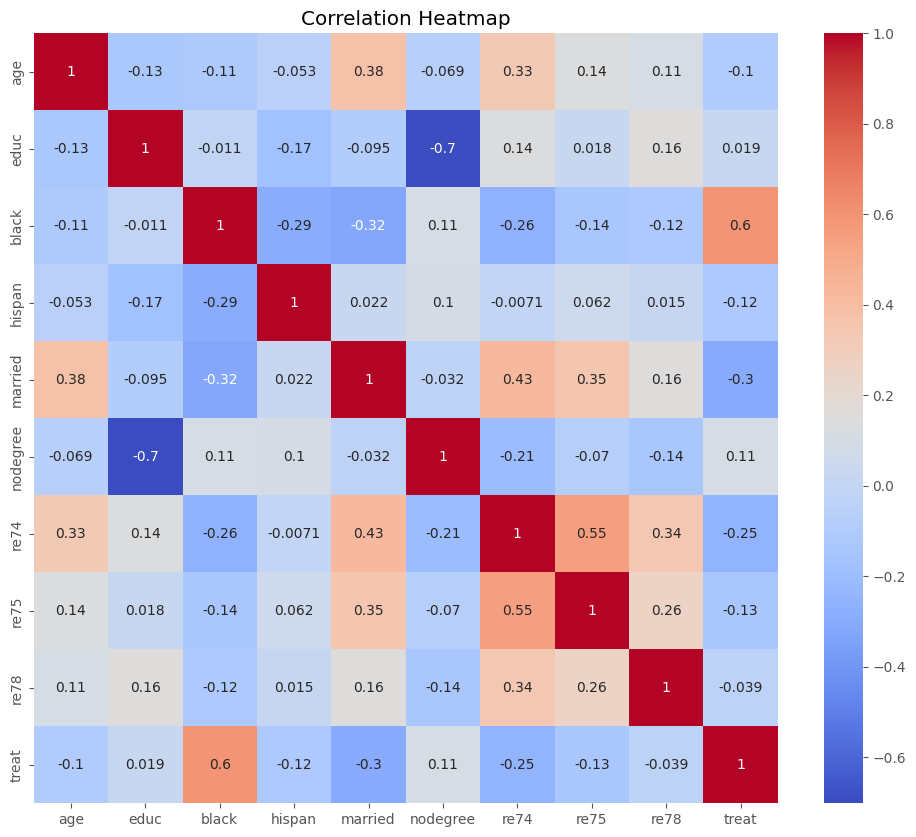

In [10]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[x_cols + [y_col, d_col]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

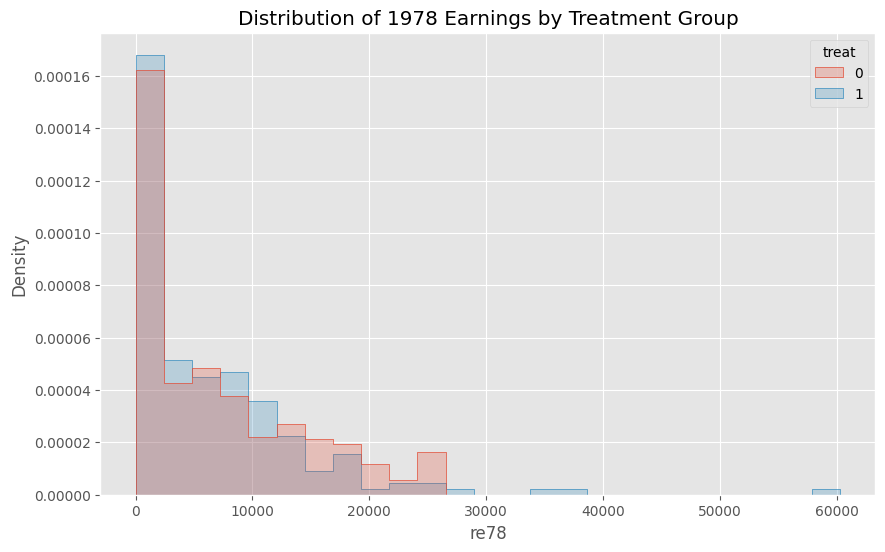

In [11]:
# Distribution of outcome variable by treatment group
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=y_col, hue=d_col, element='step', stat='density', common_norm=False)
plt.title('Distribution of 1978 Earnings by Treatment Group')
plt.show()

<br>

## DoubleML Estimation

---

In [12]:
# Specify the machine learning models
ml_g = RandomForestRegressor(n_estimators=100, max_depth=5)
ml_m = RandomForestClassifier(n_estimators=100, max_depth=5)

In [13]:
# Create and fit DoubleMLPLR model
dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)
dml_plr.fit()

print("Partial Linear Regression Results:")
print(dml_plr.summary)

Partial Linear Regression Results:
             coef     std err         t     P>|t|       2.5 %       97.5 %
treat  865.282609  796.125756  1.086867  0.277096 -695.095199  2425.660417


In [14]:
# Create and fit DoubleMLIRM model (Interactive Regression Model)
dml_irm = DoubleMLIRM(dml_data, ml_g, ml_m)
dml_irm.fit()

print("\nInteractive Regression Model Results:")
print(dml_irm.summary)


Interactive Regression Model Results:
             coef     std err         t     P>|t|        2.5 %       97.5 %
treat -136.924156  955.424712 -0.143312  0.886044 -2009.522182  1735.673869


<br>

## Comparison with Other Methods

---

In [15]:
# Naive estimate (simple difference in means)
naive_ate = df[df[d_col] == 1][y_col].mean() - df[df[d_col] == 0][y_col].mean()

print(f"Naive ATE estimate: ${naive_ate:.2f}")

Naive ATE estimate: $-635.03


In [16]:
# Simple OLS regression
import statsmodels.api as sm

X = sm.add_constant(df[x_cols + [d_col]])
ols_model = sm.OLS(df[y_col], X).fit()
print("\nOLS Regression Results:")
print(ols_model.summary())


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                Tue, 16 Jul 2024   Prob (F-statistic):           5.99e-17
Time:                        18:08:59   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6426.2110    75

<br>

## Additional Analyses

---

In [17]:
# Heterogeneous treatment effects
def het_treat_effect(df, feature):
    grouped = df.groupby(feature)
    effects = grouped.apply(lambda x: x[x[d_col] == 1][y_col].mean() - x[x[d_col] == 0][y_col].mean())
    return effects

In [18]:
# Calculate heterogeneous effects for education
het_effects_educ = het_treat_effect(df, 'educ')

/tmp/ipykernel_15664/4258532306.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  effects = grouped.apply(lambda x: x[x[d_col] == 1][y_col].mean() - x[x[d_col] == 0][y_col].mean())


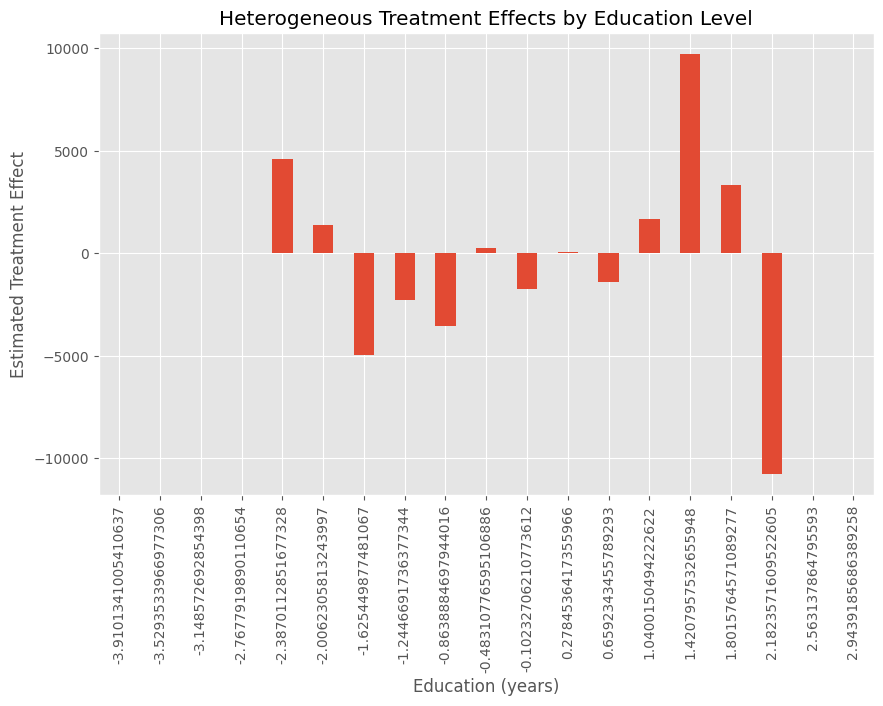

In [19]:
plt.figure(figsize=(10, 6))
het_effects_educ.plot(kind='bar')
plt.title('Heterogeneous Treatment Effects by Education Level')
plt.xlabel('Education (years)')
plt.ylabel('Estimated Treatment Effect')
plt.show()

In [20]:
# Sensitivity analysis
def sensitivity_analysis(model, n_simulations=1000):
    coef_samples = np.random.normal(model.coef[0], model.se[0], n_simulations)
    return pd.Series(coef_samples).describe()

print("\nSensitivity Analysis for DoubleMLPLR:")
print(sensitivity_analysis(dml_plr))


Sensitivity Analysis for DoubleMLPLR:
count    1000.000000
mean      911.818990
std       797.345260
min     -1831.047055
25%       365.308921
50%       948.921115
75%      1462.998798
max      3648.440956
dtype: float64


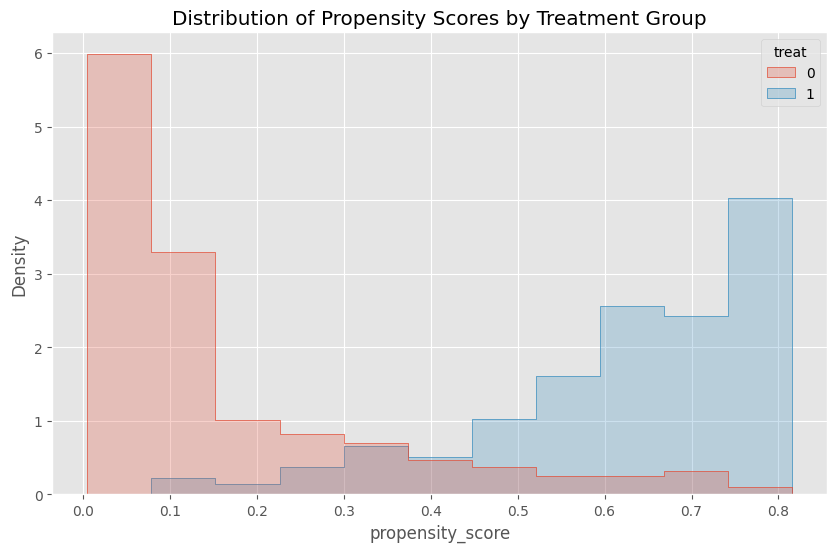

In [21]:
# Propensity score analysis
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=5)
propensity_model.fit(df[x_cols], df[d_col])
df['propensity_score'] = propensity_model.predict_proba(df[x_cols])[:, 1]

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='propensity_score', hue=d_col, element='step', stat='density', common_norm=False)
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.show()

<br>

## Results Interpretation

---

In [33]:
def interpret_results(model):
    ate = model.coef[0]
    se = model.se[0]
    ci_lower, ci_upper = dml_plr.confint().values[0]
    
    
    print(f"Estimated Average Treatment Effect: ${ate:.2f}")
    print(f"95% Confidence Interval: (${ci_lower:.2f}, ${ci_upper:.2f})")
    print(f"P-value: {model.pval[0]:.4f}")
    
    if model.pval[0] < 0.05:
        print("The treatment effect is statistically significant at the 5% level.")
    else:
        print("The treatment effect is not statistically significant at the 5% level.")
    
    print(f"This suggests that, on average, the job training program ")
    print(f"{'increased' if ate > 0 else 'decreased'} 1978 earnings by ${abs(ate):.2f}.")

# Create and fit DoubleMLPLR model with propensity score
print("\nInterpretation of DoubleMLPLR results:")
interpret_results(dml_plr)


Interpretation of DoubleMLPLR results:
Estimated Average Treatment Effect: $865.28
95% Confidence Interval: ($-695.10, $2425.66)
P-value: 0.2771
The treatment effect is not statistically significant at the 5% level.
This suggests that, on average, the job training program 
increased 1978 earnings by $865.28.
